In [1]:
#2019-10-02 18:47:03.372311
%load_ext metapack_jupyter.magic

In [2]:
CACHE_DIR='/Users/eric/Library/Application Support/metapack/'
RESOURCE_NAME='imputed_counts'
RESOLVED_URL='file:///Users/eric/proj/data-projects/downtown-partnership/datasets/sandiegodata.org-downtown_homeless/notebooks/Impute.ipynb#imputed'
WORKING_DIR='/Users/eric/proj/data-projects/downtown-partnership/datasets/sandiegodata.org-downtown_homeless'
METATAB_DOC='metapack+file:///Users/eric/proj/data-projects/downtown-partnership/datasets/sandiegodata.org-downtown_homeless/metadata.csv'
METATAB_WORKING_DIR='/Users/eric/proj/data-projects/downtown-partnership/datasets/sandiegodata.org-downtown_homeless'
METATAB_PACKAGE='metapack+file:///Users/eric/proj/data-projects/downtown-partnership/datasets/sandiegodata.org-downtown_homeless/'

In [3]:
METAPACK_BUILDING=True

In [4]:
import seaborn as sns
import metapack as mp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display 

%matplotlib inline
sns.set_context('notebook')
mp.jupyter.init()


# Imputing missing months

This notebook build a dataset that fills in the three missing months of data from the main dataset. 


In [5]:
pkg = mp.jupyter.open_package()
#pkg = mp.jupyter.open_source_package()
pkg

# Downtown San Diego Homeless Sleepers
`sandiegodata.org-dowtown_homeless-8` Last Update: 2019-10-03T01:47:02

_Five years of monthly geographic positions for homeless sleepers in Downtown San Diego_


This dataset provides geographic locations for homeless sleepers in Downtown San Diego, as counted by enumerators from the Downtown San Diego Partnership. These counts have been done monthly since 2012, and this dataset provides counts since 2014. 

<center><a
href="https://data.sandiegodata.org/wp-content/uploads/sites/18/2019/10/Homeless
-Sleepers.png"><img
src="https://data.sandiegodata.org/wp-content/uploads/sites/18/2019/10/Homeless-
Sleepers.png" width="400px"></a></center>


The count is done on paper maps with handwritten count marks. The San Diego
Regional Data Library's [Downton Homelessness
project](http://downtown-homelessness.sandiegodata.org/) converted these
scanned count maps using a [web based image annotation
tool](http://www.robots.ox.ac.uk/~vgg/software/via/).

## Base and Imputed Datasets

This distribution has two version of the homeless counts, the base set,
``homeless_counts``, which has three months of missing data, and the imputed
dataset, ``imputed_counts`` in which these three missing months, 2014-08,
2014-09, and 2015-06 are probabilistically re-created.

The Imputation process uses the total count for the month, from the
``monthly_totals`` dataset, as the number of sleepers that the imputed month
will have. Then, the imputation process collects at least 1,000 records with
dates near the missing month into a sample set, calculating the portion of
records that are in each census block. Then the algorithm randomly selects that
number of records for each census block, and adjusts random blocks so the total
of the whole set of selected records is equal to the official count for the
month.

The result is an imputed month that has the same number of records as the
official count for the month and as the same portion of sleepers in each census
block as in adjacent months.

## Notes

Notes for the source dataset, as of April 2019:

The preliminary methodology (shown in yellow) [ March 2017 and earlier] counted
two individuals per tent and two individuals per vehicle.

On April 27, 2017, the Clean & Safe program adopted the counting methodology
used by the Regional Task Force on the Homeless. Per the methodology
(represented above by the dark green cells), [April 2017 to April 2018,
inclusive ] Clean & Safe staff counted 1.75 individuals per visible
tent/structure and 1.66 individuals per vehicle that showed clear signs of
habitation.

In May 2018, the Regional Task Force on the Homeless updated the methodology
for vehicles to 2.03 that shows clear signs of habitation (the methodology of
1.75 individuals per tent/structure remained the same). The Clean & Safe
program implemented this methodology on May 31, 2018 (represented in orange).

\* Denotes the months that The Downtown Fellowship of Ministries and Churches collaborated with us on the monthly homeless sleep count.

\*\*East Village breakout areas include the following:
    * North East East Village is the area north of Market Street & east of Park Ave. 
    * North West is the area north of Market Street & west of Park Ave.
    * South East is the area east of Park Ave. south of Market Street
    * South West is the area west of Park Ave. south of Market Street

## Caveats

Because this data is extracted, manually, from manually recorded maps, there
are a lot of quality issues. 

### Missing Months

Because of conversion errors and some complications with the source maps, there
are several months of data that are excluded from this dataset

* **August 2014**. In the original datasets, August 2014 was a duplicate of September 2014. 
* **September 2014**. Comfusion related to the duplication of September and August resulted in September being incompletely processed. 
* **June 2015**. All of the map images for this month were blank. An alternate source PDF

In [6]:
pkg.resource('homeless_counts')

Header,Type,Description
neighborhood,string,"Neighborhood, from the label on the source map"
date,date,"Date of the observation. Many dates have no know day of month; for these dates, the day of month is set to 1"
type,string,"Type of sleeper: individual, vehicle or structure"
temp,float,"Temperature, if it was written on the source map"
rain,string,"Rain or clear, if it was written on the source map"
geoid,string,"Census geoid for the 2010 Census block the observation is in, in ACS format"
x,number,"X geographic position, in California State Plane 6, EPSG:2230"
y,number,"Y geographic position, in California State Plane 6, EPSG:2230"
geometry,string,"Geographic position of observation, in Lat/Lon, EPSG:4326"


In [7]:
df = pkg.resource('homeless_counts').dataframe()
df['date'] = pd.to_datetime(df.date)
df['records'] = 1
df['month_start_date'] = df.date.apply(lambda v: pd.to_datetime(v.strftime('%Y-%m-01')))

In [8]:
from rowgenerators import dataframe
t = df.set_index('date')

t['imputed'] = False

t = t.groupby(pd.Grouper(freq="MS")).records.count().to_frame()
missing_records = t[t.records == 0].index
missing_records.sort_values()

missing_date = missing_records[0]
missing_date  - pd.offsets.MonthBegin(2)

mt = dataframe('../data/monthly_totals.csv#&encoding=ascii')
mt['date'] = pd.to_datetime(mt.date)
mt.set_index('date', inplace=True)


In [9]:
def sampled_counts(mr_index):
    """Select a suitable set of records to use as samples for selecting sleepings for
    a missing month, then select a number for each, proportional to the proportion of sleepers in that block. 
    The result is a set of new imputed records that matches the number of record in the official states and
    has the right portion of sleepers in each block. """
    
    import random
    
    # Find a range for selecting samples that is around the missing date and sifficiently large
    missing_date = missing_records[mr_index]

    t = df.set_index('month_start_date').sort_index()
    for i in range(10):
        min_date, max_date = missing_date  - pd.offsets.MonthBegin(i), missing_date  + pd.offsets.MonthBegin(i)

        # COllect at least 1,000 records for the sample set. 
        if len(t.loc[min_date:max_date]) > 1000:
            break

   
    t = t.loc[min_date: max_date].groupby('geoid').records.sum()
    block_prop = t / t.sum()  # proportion of sleepers in each block

    target_count = mt.loc[missing_records].iloc[mr_index]['count']

    sleepers_per_block = (block_prop * target_count).round() # Number of samples per census block
    
    actual_count = sleepers_per_block.sum()

    # +1 or -1, depending on wether the actual value is larger or smaller than target
    inc = int(abs(target_count - actual_count)) / int(target_count - actual_count)

    # Randomly select a number of rows to tweak equal to the diff between the target and actual
    # but only rows that have 5 or more sleepers,
    shuffled_index = list(sleepers_per_block.index)
    np.random.shuffle(shuffled_index)
   
    for idx in shuffled_index:
        if sleepers_per_block.loc[idx] + inc > 0: 
            sleepers_per_block.loc[idx] += inc
            
        actual_count = sleepers_per_block.sum()
        
        if actual_count == target_count:
            break
        
    assert sleepers_per_block.sum() == target_count, (len(t), inc, actual_count, target_count, sleepers_per_block.sum())
    
    # Now sleepers_per_block has the number of records we need to sample for each block. 
    
    rows = []
    
    for idx, row in sleepers_per_block.to_frame().iterrows():
        
        
        sample_index = np.random.choice(list(df[df.geoid==idx].index),int(row.records))
    
        
        for idx in sample_index:
            row = df.loc[idx].copy()
            row.rain = ''
            row.temp = np.nan
            row.date = missing_date
           
            rows.append(row)
            
    impute =  pd.DataFrame(rows)
    
    assert len(impute) == target_count
    
    return impute 
    
    
imputes = None

for e in range(len(missing_records)):

    t = sampled_counts(e)
    
    if imputes is None:
        imputes = t
    else:
        imputes = pd.concat([imputes, t])
   
imputes.head()

,neighborhood,date,type,temp,rain,geoid,x,y,geometry,records,month_start_date
18289,east_village,2014-08-01,individual,NaN,,10100US060730051001001,6.285052e+06,1.839645e+06,"POLYGON ((-117.148549 32.710455, -117.148728 3...",1,2014-06-01
17869,east_village,2014-08-01,individual,NaN,,10100US060730051001001,6.285044e+06,1.839747e+06,"POLYGON ((-117.148549 32.710455, -117.148728 3...",1,2016-04-01
17758,east_village,2014-08-01,individual,NaN,,10100US060730051001001,6.285050e+06,1.839761e+06,"POLYGON ((-117.148549 32.710455, -117.148728 3...",1,2016-03-01
18030,east_village,2014-08-01,individual,NaN,,10100US060730051001001,6.285058e+06,1.839703e+06,"POLYGON ((-117.148549 32.710455, -117.148728 3...",1,2016-09-01
17743,east_village,2014-08-01,individual,NaN,,10100US060730051001001,6.285054e+06,1.839759e+06,"POLYGON ((-117.148549 32.710455, -117.148728 3...",1,2014-10-01


In [10]:
imputes.head().T

,18289,17869,17758,18030,17743
neighborhood,east_village,east_village,east_village,east_village,east_village
date,2014-08-01 00:00:00,2014-08-01 00:00:00,2014-08-01 00:00:00,2014-08-01 00:00:00,2014-08-01 00:00:00
type,individual,individual,individual,individual,individual
temp,NaN,NaN,NaN,NaN,NaN
rain,,,,,
geoid,10100US060730051001001,10100US060730051001001,10100US060730051001001,10100US060730051001001,10100US060730051001001
x,6.28505e+06,6.28504e+06,6.28505e+06,6.28506e+06,6.28505e+06
y,1.83965e+06,1.83975e+06,1.83976e+06,1.8397e+06,1.83976e+06
geometry,"POLYGON ((-117.148549 32.710455, -117.148728 3...","POLYGON ((-117.148549 32.710455, -117.148728 3...","POLYGON ((-117.148549 32.710455, -117.148728 3...","POLYGON ((-117.148549 32.710455, -117.148728 3...","POLYGON ((-117.148549 32.710455, -117.148728 3..."
records,1,1,1,1,1


In [11]:
imputed = pd.concat([df, imputes]).sort_values('date').drop(columns=['records','month_start_date'])

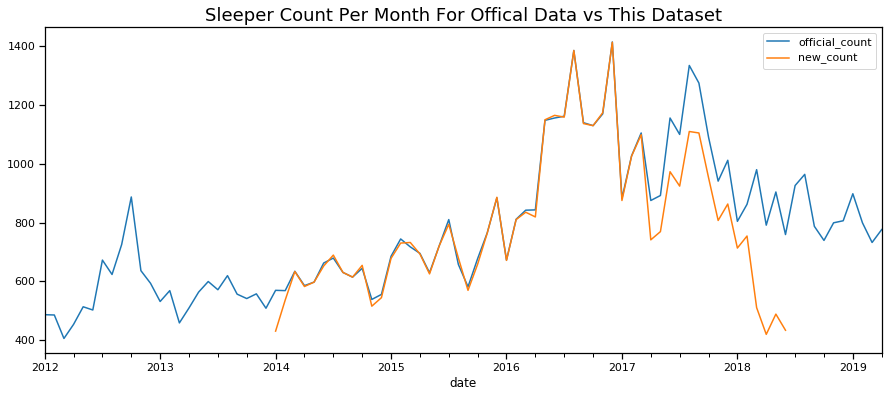

In [12]:
t = imputed.copy()

t['new_count'] = 1
t = t.set_index('date').groupby(pd.Grouper(freq="MS")).new_count.count().to_frame()
mt = pkg.resource('monthly_totals').dataframe().set_index('date').groupby(pd.Grouper(freq="MS")).sum().rename(columns={'count':'official_count'})

j = mt.join(t)
ax = j.plot(figsize=(15,6))
ax.set_title('Sleeper Count Per Month For Offical Data vs This Dataset', fontsize=18);

In [13]:
missing_records

DatetimeIndex(['2014-08-01', '2014-09-01', '2015-06-01'], dtype='datetime64[ns]', name='date', freq=None)

In [14]:
%mt_materialize imputed '/Users/eric/Library/Application Support/metapack/_materialized_data/sandiegodata.org-dowtown_homeless-8' 

{
    "df_name": "imputed",
    "path": "/Users/eric/Library/Application Support/metapack/_materialized_data/sandiegodata.org-dowtown_homeless-8/imputed.csv"
}


In [15]:

%mt_materialize_all '/Users/eric/Library/Application Support/metapack/_materialized_data/sandiegodata.org-dowtown_homeless-8'


[]


In [16]:

%mt_show_metatab



Declare: metatab-latest
Section: Resources|Name|Title|Description|StartLine|HeaderLines|Encoding


In [17]:

%mt_show_libdirs



[]
